In [1]:
from keras import models, backend
from keras.layers import Input, Conv2D, MaxPooling2D ,Dropout, Activation
from keras.layers import UpSampling2D , BatchNormalization,Concatenate

In [2]:
class UNET(models.Model):
    def __init__(self, org_shape, n_ch):
        ic = 3 if backend.image_data_format() == 'channels_last' else 1        
        
        def conv(x,n_f,mp_flag=True):
            x = MaxPooling2D((2,2),padding='same')(x) if mp_flag else x
            x = Conv2D(n_f,(3,3), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('tanh')(x)
            x = Dropout(0.05)(x)
            x =Conv2D(n_f,(3,3),padding ='same')(x)
            x = BatchNormalization()(x)
            x = Activation('tanh')(x)
            return x

        def deconv_unet(x,e,n_f):
            x = UpSampling2D((2,2))(x)
            x = Concatenate(axis= ic)([x,e])
            x = Conv2D(n_f,(3,3),padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('tanh')(x)
            x = Conv2D(n_f,(3,3),padding ='same')(x)
            x = BatchNormalization()(x)
            x = Activation('tanh')(x)
            return x
        
        original =Input(shape=org_shape)
        
        c1 = conv(original , 16, mp_flag=False)
        c2 = conv(c1,32)
        
        encoded = conv(c2 ,64)
        
        x = deconv_unet(encoded,c2,32)
        x = deconv_unet(x,c1,16)
        
        decoded = Conv2D(n_ch, (3,3),activation='sigmoid', padding='same')(x)
        super().__init__(original,decoded)
        self.compile(optimizer ='adadelta', loss ='mse') 
    
    
        

In [4]:
from keras import datasets, utils

In [19]:
class DATA():
    def __init__(self,in_ch =None):
        (x_train,y_train), (x_test,y_test)  = datasets.cifar10.load_data()
        
        if x_train.ndim ==4:
            if backend.image_data_format() =='channels_first':
                n_ch , img_rows, img_cols = x_train.shape[1:]
            else :
                img_rows, img_cols, n_ch = x_train.shape[1:]
        else:
            img_rows, img_cols = x_train.shape[1:]
            n_ch =1
        
        in_ch = n_ch if in_ch is None else in_ch
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        x_train /= 255
        x_test /= 255
    
        def RGB2Gray(X, fmt):
            if fmt =='channel_first':
                R = X[:,0:1]
                G = X[:,1:2]
                B = X[:,2:3]
            else:
                R = X[...,0:1]
                G = X[...,1:2]
                B = X[...,2:3]

            return 0.299*R + 0.587*G + 0.114*B
        
        if backend.image_data_format()=='channel_first':
            x_train_out = x_train.reshape(x_train.shape[0],n_ch,img_rows,img_cols)
            x_test_out = x_test.reshape(x_test.shape[0],n_ch,img_rows,img_cols)
            input_shape =(in_ch,img_rows,img_cols)
        else:
            x_train_out = x_train.reshape(x_train.shape[0],img_rows,img_cols,n_ch)
            x_test_out = x_test.reshape(x_test.shape[0],img_rows,img_cols,n_ch)
            input_shape =(img_rows,img_cols,in_ch)
    
        if in_ch ==1 and n_ch ==3:
            x_train_in = RGB2Gray(x_train_out,backend.image_data_format())
            x_test_in =RGB2Gray(x_test_out, backend.image_data_format())
        elif in_ch ==2 and n_ch ==3:
            x_train_in, x_test_in =RGB2RG(x_train_out, x_test_out,backend.image_data_format())
        else:
            x_train_in = x_train_out
            x_test_in = x_test_out
            
        self.input_shape = input_shape
        self.x_train_in ,self.x_train_out = x_train_in,x_train_out
        self.x_test_in ,self.x_test_out = x_test_in,x_test_out
        self.n_ch = n_ch
        self.in_ch = in_ch
        
        
    

In [20]:
from skeras import plot_loss

In [21]:
import matplotlib.pyplot as plt
import numpy as np

In [32]:
def show_images(data,unet):
    x_test_in = data.x_test_in
    x_test_out = data.x_test_out
    decoded_imgs = unet.predict(x_test_in)
    
    if backend.image_data_format() == 'channels_first':
        print(x_test_out.shape)
        x_test_out= x_test_out.swapaxes(1,3).swapaxes(1,2)
        print(x_test_out.shape)
        decoded_imgs = decoded_imgs.swapaxes(1,3).swapaxes(1,2)
        if data.in_ch == 1:
            x_test_in = x_test_in[:,0,...]
        elif data.in_ch ==2:
            print(x_test_out.shape)
            x_test_in_tmp = np.zeros_like(x_test_out)
            x_test_in = x_test_in.swapaxes(1,3).swapaxes(1,2)
            x_test_in_tmp[...,:2] = x_test_in
            x_test_in = x_test_in_tmp
        else:
            x_test_in = x_test_in.swapaxes(1,3).swapaxes(1,2)
        
    else:
        if data.in_ch ==1:
            x_test_in = x_test_in[...,0]
        elif data.in_ch ==2:
            x_test_in_tmp =np.zeros_like(x_test_out)
            x_test_in_tmp[...,:2] = x_test_in
            x_test_in = x_test_tmp
    
    n = 10 
    plt.figure(figsize=(20,6))
    for i in range(n):
        ax = plt.subplot(3,n,i+1)
        plt.imshow(x_test_in[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3,n,i+1)
        plt.imshow(decoded_imgs[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3,n,i+1+n*2)
        plt.imshow(x_test_out[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 32s 802us/step - loss: 0.0136 - val_loss: 0.0132
Epoch 2/10
40000/40000 [==============================] - 30s 739us/step - loss: 0.0092 - val_loss: 0.0097
Epoch 3/10
40000/40000 [==============================] - 30s 738us/step - loss: 0.0083 - val_loss: 0.0088
Epoch 4/10
40000/40000 [==============================] - 30s 740us/step - loss: 0.0078 - val_loss: 0.0075
Epoch 5/10
40000/40000 [==============================] - 29s 736us/step - loss: 0.0075 - val_loss: 0.0078
Epoch 6/10
40000/40000 [==============================] - 29s 736us/step - loss: 0.0073 - val_loss: 0.0145
Epoch 7/10
40000/40000 [==============================] - 29s 735us/step - loss: 0.0071 - val_loss: 0.0099
Epoch 8/10
40000/40000 [==============================] - 29s 736us/step - loss: 0.0070 - val_loss: 0.0095
Epoch 9/10
40000/40000 [==============================] - 29s 737us/step - loss: 0.0069 - val_

NameError: name 'backed' is not defined

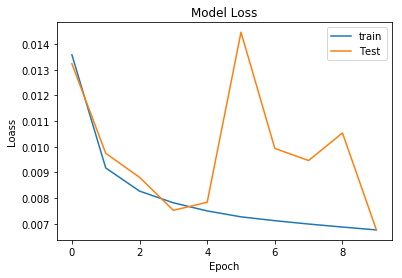

In [31]:
in_ch =1
epochs=10
batch_size = 128
fig= True
data =DATA(in_ch=in_ch)
unet =UNET(data.input_shape, data.n_ch)
his = unet.fit(data.x_train_in,data.x_train_out,epochs =epochs, batch_size = batch_size ,shuffle = True, validation_split= 0.2)
   
if fig:
    plot_loss(his)
    

C:\Users\jang\AppData\Local\conda\conda\envs\TF\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


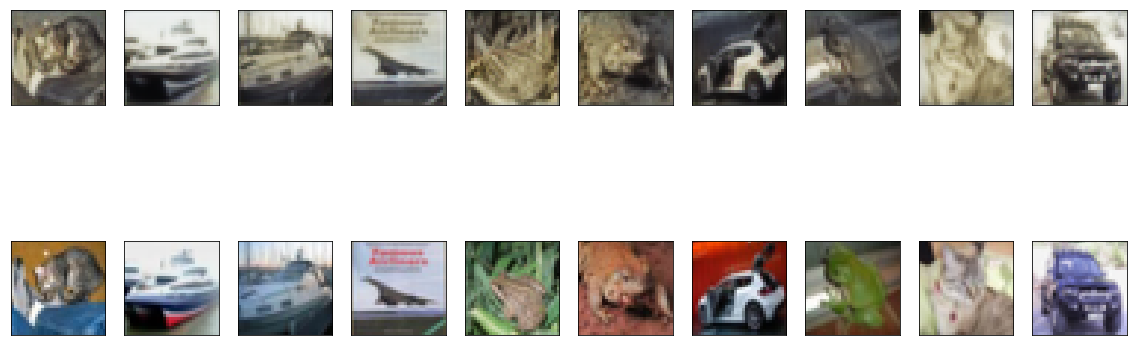

In [33]:
show_images(data,unet)